# Monotonic Tau ID

In [1]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib
from keras import optimizers


import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

#For MonoTau setup
import torch
from torch.nn.functional import binary_cross_entropy_with_logits
import matplotlib.pyplot as plt

from monotonenorm import direct_norm, SigmaNet, GroupSort

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

model_name = '../models/MonoTauID.h5'

2023-06-14 11:35:08.361979: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 11:35:08.499108: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-14 11:35:08.502921: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /work/submit/dhoang/DQ/core-inst/lib:/cvmfs/seaquest.opensciencegrid.org/seaquest/s

# Create training/testing data

In [2]:
#You only need to run this once
def create_train_test_data(dir_path, test_index=400000, train=True):
    '''
    test_index: 400000 
    All the data before test_index are used for training. And all the data after it is used for testing.
    '''
    
    sig = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    bkg = uproot4.open(dir_path+"/test_bkg_v12_emseed.root")
    qcd = uproot4.open(dir_path+"/test_qcd_v12_emseed.root")
    
    if train:
        sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
        bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
        qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()
        
        truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[:test_index]
        reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[:test_index]
        deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[:test_index]
        eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[:test_index]
        selection_sig = (truth_pt_sig > 20.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
        
        reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[:test_index]
    else:
        sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
        bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
        qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()
        
        truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
        reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[test_index:]
        deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
        eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]
        selection_sig = (truth_pt_sig > 20.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
        
        reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[test_index:]

    selection_bkg = reco_pt_bkg > 20.
    reco_pt_qcd = qcd['ntuplePupSingle']['tree']['pt'].array()
    selection_qcd = reco_pt_qcd > 20.
    
    X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
    y_sig = np.full(X_sig.shape[0], 1.)
    
    X_bkg = np.nan_to_num(np.asarray(bkg_input)[selection_bkg])
    y_bkg = np.full(X_bkg.shape[0], 0.)

    X_qcd = np.nan_to_num(np.asarray(qcd_input)[selection_qcd])
    y_qcd = np.full(X_qcd.shape[0], 0.)
        
    X = np.concatenate([X_sig, X_bkg, X_qcd])
    y = np.concatenate([y_sig, y_bkg, y_qcd])
    
    X[abs(X) > 1e+9] = 0.
    
    assert not np.any(np.isnan(X))
    assert not np.any(np.isnan(y))
    
    return torch.from_numpy(X), torch.from_numpy(y)


In [3]:
X_train, y_train = create_train_test_data("../../ntuples/Jan_25_2023",train=True)
X_test, y_test = create_train_test_data("../../ntuples/Jan_25_2023",train=False)

# Train the monotonic network

In [4]:
contraint_index_part = [1] + [0]*7
contraint_index = contraint_index_part*10

monotonic = True
LIP = 1  # lipschitz constant of the model
EPOCHS = 500

In [5]:
def get_model(monotonic):
    def lipschitz_norm(module):
          return direct_norm(
              module,  # the layer to constrain
              "one-inf",  # |W|_1 constraint type
              max_norm=LIP ** (1 / 4),  # norm of the layer (LIP ** (1/nlayers))
              )

    model = torch.nn.Sequential(
      lipschitz_norm(torch.nn.Linear(80, 25)),
      GroupSort(5),
      lipschitz_norm(torch.nn.Linear(25, 10)),
      GroupSort(5),
      lipschitz_norm(torch.nn.Linear(10, 10)),
      GroupSort(5),
      lipschitz_norm(torch.nn.Linear(10, 1)),
    )

    if monotonic:
        model = SigmaNet(
          model,
          sigma=LIP,
          monotone_constraints=contraint_index,
          # 0: don't constrain feature monotonicity,
          # 1: monotonically increasing,
          # -1: monotonically decreasing
          # for each feature individually
        )
        
    return model

In [6]:
model = get_model(monotonic)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [7]:
for i in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = binary_cross_entropy_with_logits(y_pred, y_train.view(-1, 1).float())
    loss.backward()
    optimizer.step()

# ROC Curve

In [12]:
NormalModel = load_model('../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5')
    
y_pred_mono = model(X_test)
fpr_mono, tpr_mono, _ = roc_curve(y_test, y_pred_mono.detach().numpy())
auc_score_mono = round(auc(fpr_mono, tpr_mono),2)

y_pred_normal = NormalModel.predict(X_test.detach().numpy())
fpr_normal, tpr_normal, _ = roc_curve(y_test,y_pred_normal)
auc_score_normal = round(auc(fpr_normal, tpr_normal),2)

7126/7126 [==============================] - 3s 475us/step


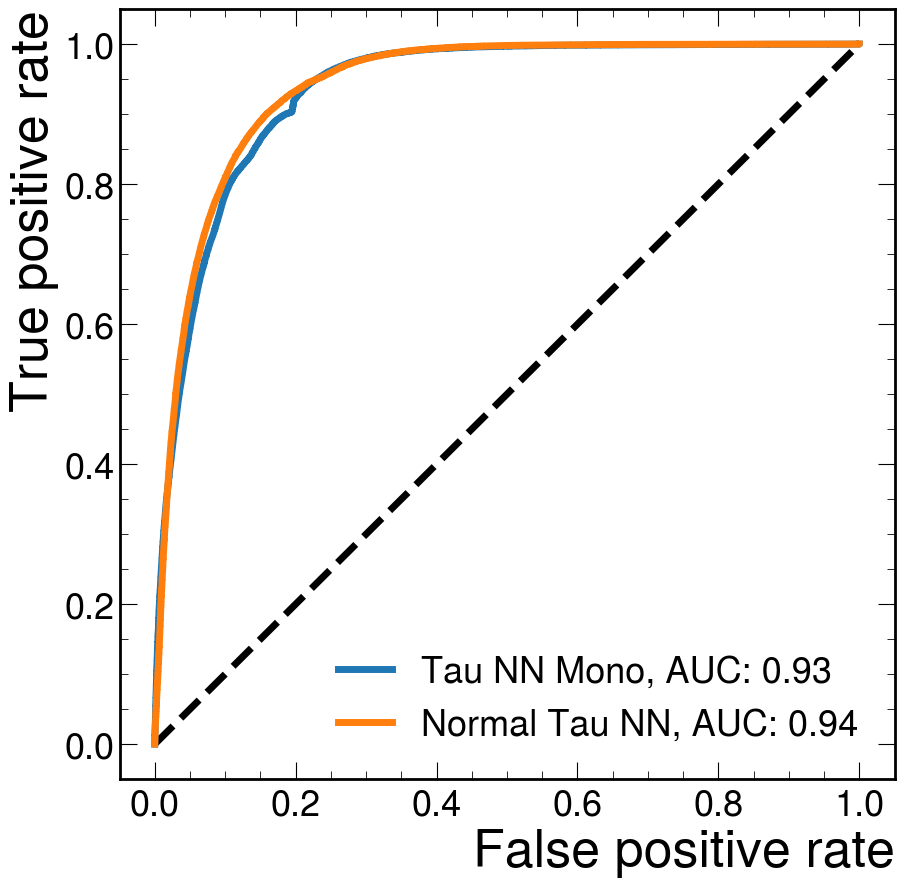

In [14]:
#Create plot for ROC
plt.figure(1)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_mono, tpr_mono, label = 'Tau NN Mono, AUC: {}'.format(auc_score_mono))
plt.plot(fpr_normal, tpr_normal, label = 'Normal Tau NN, AUC: {}'.format(auc_score_normal))

#Establish labels and save image
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show()

## Make efficiency plots

In [15]:
def plot_pt_eff_puppi(MonoModel,
                      normal_model,
                      DataPath,
                      TreeName='ntuplePupSingle',
                      test_indx=400000,
                      cut_point = 0.28):
    '''
    cut_point = 0.28. We accept anything larger than this. 
    The corresponding corrected pT cut is 30 GeV.

    dir_path: directory path where the data is saved,
    '''

    sig = uproot4.open(DataPath)
    truth_tau_pt = sig[TreeName]['tree']['genpt1'].array()[test_indx:]
    reco_tau_pt = sig[TreeName]['tree']['pt'].array()[test_indx:]

    #Load model and select out the tau
    NormalModel = load_model(normal_model)

    #Get all the inputs
    sig_input = sig[TreeName]['tree']['m_inputs'].array()[test_indx:]

    reco_pt_sig = sig[TreeName]['tree']['pt'].array()[test_indx:]
    deltaR_sig = sig[TreeName]['tree']['gendr1'].array()[test_indx:]
    eta_sig = sig[TreeName]['tree']['geneta1'].array()[test_indx:]

    selection_deno = (truth_tau_pt > 1.) & (abs(eta_sig) < 2.1) #"genpt1 > 1. && abs(geneta1) < 2.1 "
    selection_num = selection_deno & (abs(deltaR_sig) < 0.4) & (reco_pt_sig>1.) # " abs(gendr1) < 0.4 && pt > 1."

    #Selected out the tau pt with the basic cuts first
    truth_tau_pt_select = truth_tau_pt[selection_num]

    X_sig = np.nan_to_num(np.asarray(sig_input[selection_num]))
    
    y_sig_normal = NormalModel.predict(X_sig)
    y_sig_mono = MonoModel(torch.from_numpy(X_sig))

    nn_cut_normal = y_sig_normal.flatten() > cut_point
    nn_cut_mono = y_sig_mono.detach().numpy().flatten() > cut_point
    
    tau_pt_nn_normal = np.asarray(truth_tau_pt_select)[nn_cut_normal]
    tau_pt_nn_mono = np.asarray(truth_tau_pt_select)[nn_cut_mono]

    #Fill two plots and divide the two.
    pT_egdes = [0,10,15,20,25,30,35,40,45,50,55,60,70,80,100,125,150] #200?
    pT_axis = hist.axis.Variable(pT_egdes, name = r"$ \tau_h$ $p_T^{gen}$")

    hist_all_tau = Hist(pT_axis)
    hist_selected_puppi = Hist(pT_axis)
    hist_selected_tau_normal = Hist(pT_axis)
    hist_selected_tau_mono = Hist(pT_axis)

    hist_all_tau.fill(truth_tau_pt[selection_deno])
    hist_selected_puppi.fill(truth_tau_pt_select)
    hist_selected_tau_normal.fill(tau_pt_nn_normal)
    hist_selected_tau_mono.fill(tau_pt_nn_mono)

    %matplotlib inline
    fig = plt.figure(figsize=(10, 12))
    _, eff_new_nn_artists_normal = hist_selected_tau_normal.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (New NN Score > {})".format(cut_point),
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )
    
    fig = plt.figure(figsize=(10, 12))
    _, eff_new_nn_artists_mono = hist_selected_tau_mono.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (New NN Score > {})".format(cut_point),
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    fig = plt.figure(figsize=(10, 12))
    _, eff_puppi_artists = hist_selected_puppi.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (PUPPI)",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    #The real efficiency plot
    fig = plt.figure()

    eff_new_nn_x_normal = [eff_new_nn_artists_normal.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists_normal.bar.patches))]
    eff_new_nn_y_normal = [eff_new_nn_artists_normal.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists_normal.bar.patches))]
    eff_new_nn_err_normal = [eff_new_nn_artists_normal.bar.patches[i].get_height() for i in range(len(eff_new_nn_artists_normal.bar.patches))]
    
    eff_new_nn_x_mono = [eff_new_nn_artists_mono.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists_mono.bar.patches))]
    eff_new_nn_y_mono = [eff_new_nn_artists_mono.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists_mono.bar.patches))]
    eff_new_nn_err_mono = [eff_new_nn_artists_mono.bar.patches[i].get_height() for i in range(len(eff_new_nn_artists_mono.bar.patches))]

    eff_puppi_x = [eff_puppi_artists.bar.patches[i].get_x() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_y = [eff_puppi_artists.bar.patches[i].get_y() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_err =  [eff_puppi_artists.bar.patches[i].get_height() for i in range(len(eff_puppi_artists.bar.patches))]

    plt.errorbar(eff_new_nn_x_normal, eff_new_nn_y_normal, yerr=eff_new_nn_err_normal,
                fmt='o',
                linewidth=2,
                label = 'Retrained Tau NN (> {})'.format(cut_point))
    
    plt.errorbar(eff_puppi_x, eff_puppi_y, yerr=eff_puppi_err,
                fmt='o',
                linewidth=2,
                label = 'PUPPI')
    
    plt.errorbar(eff_new_nn_x_mono, eff_new_nn_y_mono, yerr=eff_new_nn_err_mono,
                fmt='o',
                linewidth=2,
                label = 'Mono Tau NN (> {})'.format(cut_point))


    plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
    plt.ylim([0.,1.1])
    plt.xlim([0,150])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
    plt.ylabel(r"$\epsilon$(Di-$\tau_h$ trigger rate at 11 kHz)")
    plt.legend(loc = 'lower right')
    plt.show()

1905/1905 [==============================] - 1s 468us/step


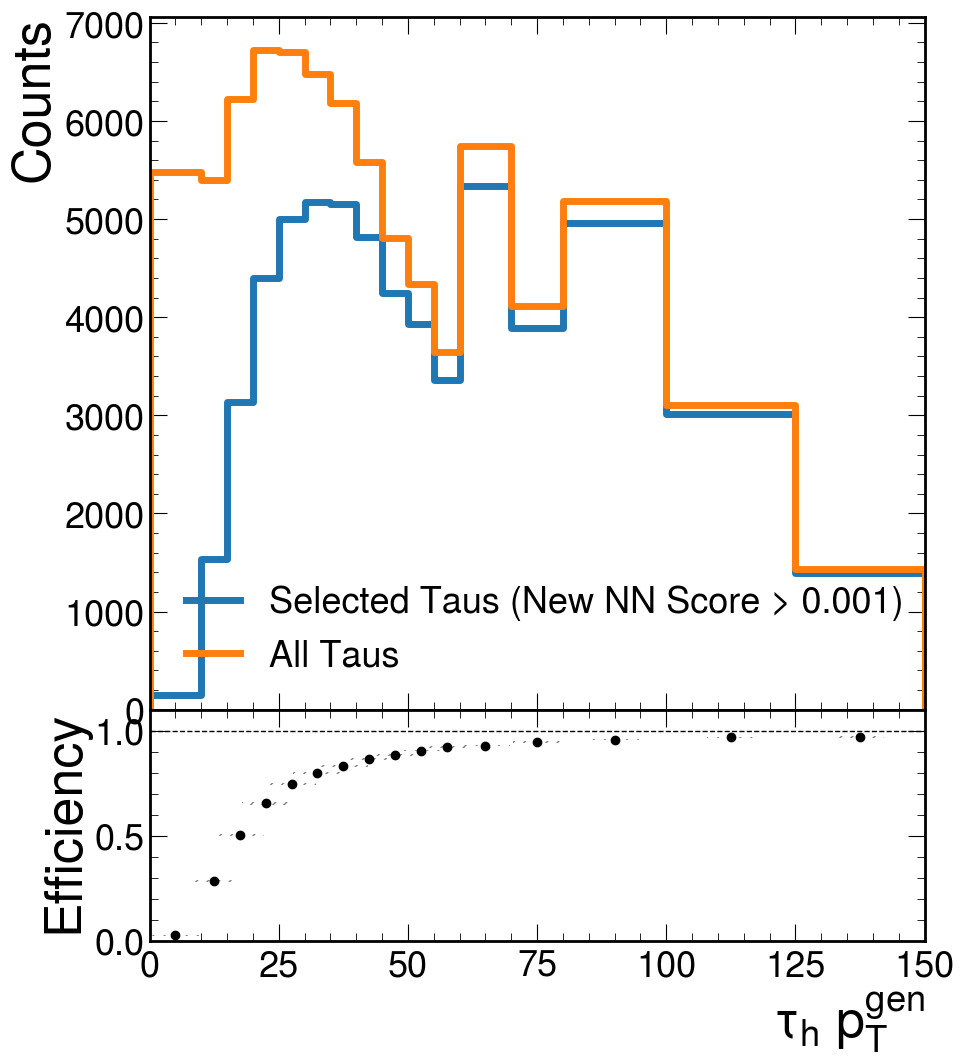

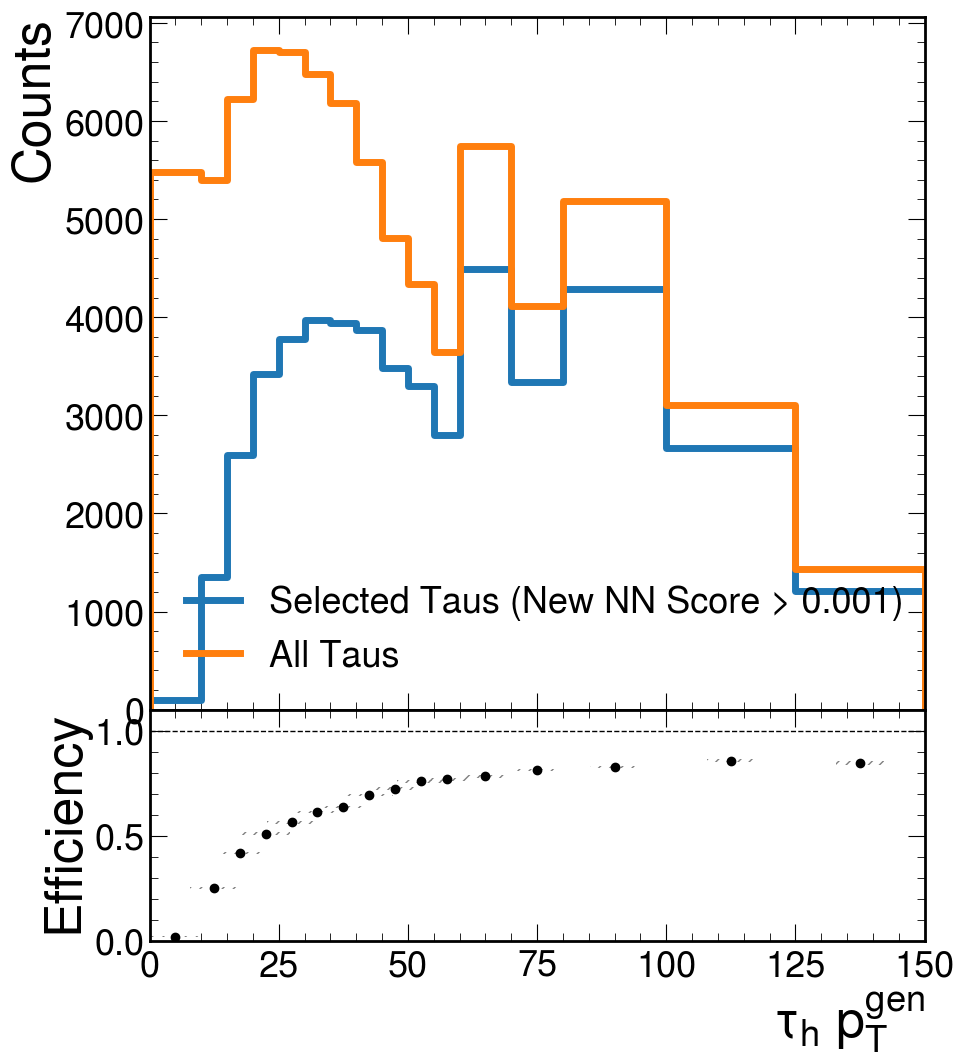

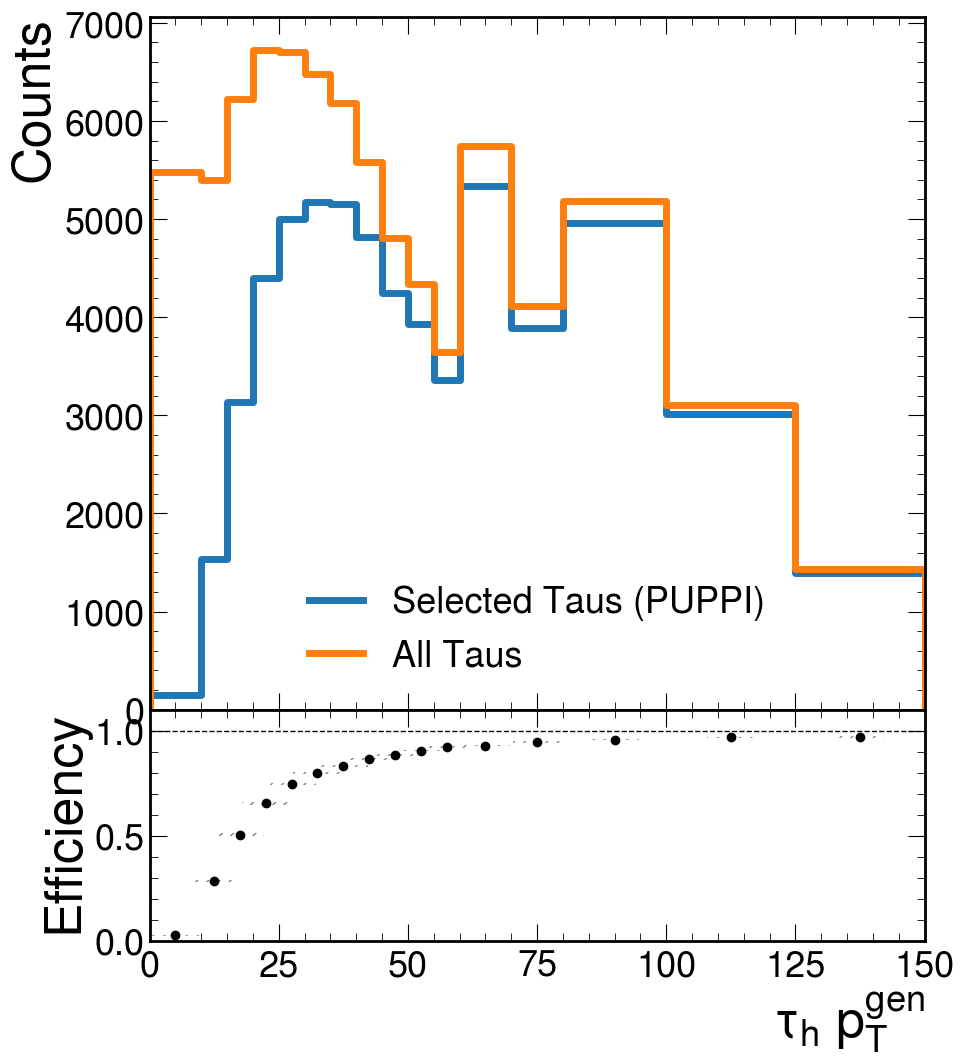

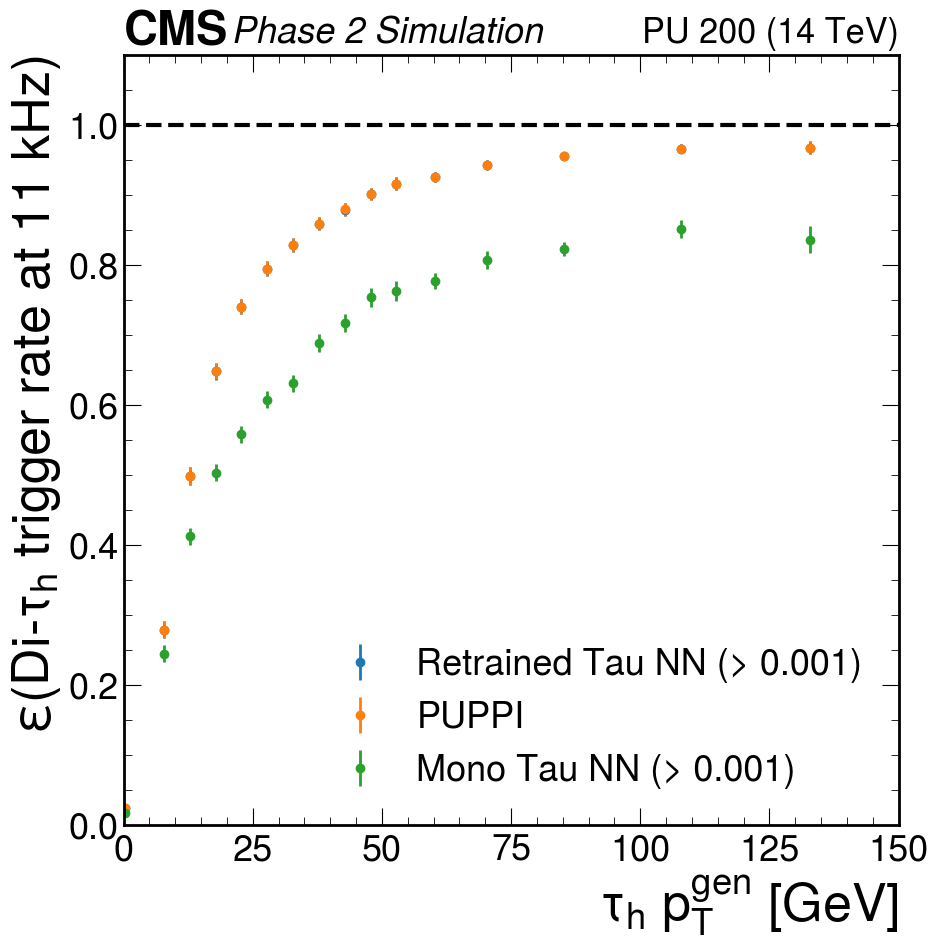

In [18]:
plot_pt_eff_puppi(MonoModel=model,
                  normal_model = '../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5',
                  DataPath='../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                  TreeName='ntuplePupSingle',
                  test_indx=400000,
                  cut_point = 0.001)